# NLP - ASSIGNMENT 5
## Özge Bülbül - 2220765008

### Section 1


Beginning imports are below, however; I made the rest of the imports in between code lines when i needed them.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
train_df = pd.read_csv("/content/drive/MyDrive/train.csv", header=None)
test_df = pd.read_csv("/content/drive/MyDrive/test.csv", header=None)

In [14]:
train_df

,0,1
0,text,label
1,"U.S. Strikes Zarqawi Network, Killing 15 BAGHD...",0
2,MGM shares jump 7.5 pct; report suggests deal ...,2
3,Logitech launches laser-tracking mouse SAN FRA...,3
4,Orb Unveils New Service for Digital Media (AP)...,3
...,...,...
29996,Two Apes Arrive at Education Center (AP) AP - ...,3
29997,Japan Greets U.S. Army Deserter Jenkins (AP) A...,0
29998,Supreme Court Debates Teenage Executions WASHI...,0
29999,"Stocks End Flat, Microsoft Lifts Techs NEW YO...",2


In [15]:
test_df.head()

,0,1
0,text,label
1,Fan v Fan: Manchester City-Tottenham Hotspur T...,1
2,Paris Tourists Search for Key to 'Da Vinci Cod...,0
3,Net firms: Don't tax VoIP The Spanish-American...,3
4,Dependent species risk extinction The global e...,3


After converting csvs to dfs, I printed the column names and renamed them to be text and label. Then I deleted the first row as it didn't contain data, it contained the column names.

In [16]:
print(train_df.columns)


Index([0, 1], dtype='int64')


In [17]:
train_df = train_df.rename(columns={0: 'text', 1: 'label'})

In [18]:
test_df = test_df.rename(columns={0: 'text', 1: 'label'})

In [19]:
print(train_df.iloc[0])

text      text
label    label
Name: 0, dtype: object


In [20]:
train_df = train_df.drop(index=0).reset_index(drop=True)
test_df = test_df.drop(index=0).reset_index(drop=True)

Below, I showed that the dataset is balanced as it has an equal amount of each label.

In [21]:
train_df['label'].value_counts()

,count
label,
0,7500
2,7500
3,7500
1,7500


I did a null check and a duplicate check, both were zero.

In [22]:
train_df.isnull().sum()

,0
text,0
label,0


In [23]:
print(train_df.duplicated(subset='text').sum())

0


In [24]:
train_df['text_length'] = train_df['text'].apply(len)

Most articles are between 250–350 characters long, with an average of 316. Only a few are much longer (max is 1012), so BERT can handle most without truncation.

In [25]:
train_df['text_length'].describe()


,text_length
count,30000.000000
mean,315.586900
std,71.037516
min,251.000000
25%,277.000000
50%,292.000000
75%,325.000000
max,1012.000000


Most articles have around 49 words, with most ranging between 43 and 51. The shortest has 15 words, and the longest has 177.

In [27]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
train_df['word_count'].describe()

,word_count
count,30000.000000
mean,49.099733
std,10.475755
min,15.000000
25%,43.000000
50%,47.000000
75%,51.000000
max,177.000000


Label 1 has the shortest articles on average. Label 3 has the longest articles on average and the highest variability. All labels have a minimum text length close to 250–270, but maximums vary, with Label 3 reaching up to 1,012 characters.

In short: Article length varies slightly by category, Label 3 tends to be the longest and most variable.

In [28]:
length_stats_by_label = train_df.groupby('label')['text_length'].describe()
length_stats_by_label

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,7500.0,318.859333,57.268519,276.0,285.0,297.0,325.0,865.0
1,7500.0,289.633067,43.928466,251.0,262.0,276.0,298.0,853.0
2,7500.0,319.563600,68.312071,267.0,277.0,292.0,336.0,1006.0
3,7500.0,334.291600,96.235498,268.0,281.0,299.0,348.0,1012.0


Most articles are similar in length, but Label 3 tends to have more words and more variety, while Label 2 is the most concise.

In [29]:
word_stats_by_label = train_df.groupby('label')['word_count'].describe()
word_stats_by_label

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,7500.0,50.651333,9.900662,34.0,45.0,48.0,53.0,145.0
1,7500.0,48.538133,8.289228,33.0,43.0,47.0,51.0,151.0
2,7500.0,46.302800,7.105733,15.0,43.0,45.0,49.0,134.0
3,7500.0,50.906667,14.421210,16.0,43.0,47.0,53.0,177.0


This boxplot shows the distribution of text lengths (in characters) across four different labels (0, 1, 2, 3). All labels have similar median lengths, but label 3 has the widest spread and the most outliers, suggesting greater variability in text length. Label 1 appears to have shorter texts on average.

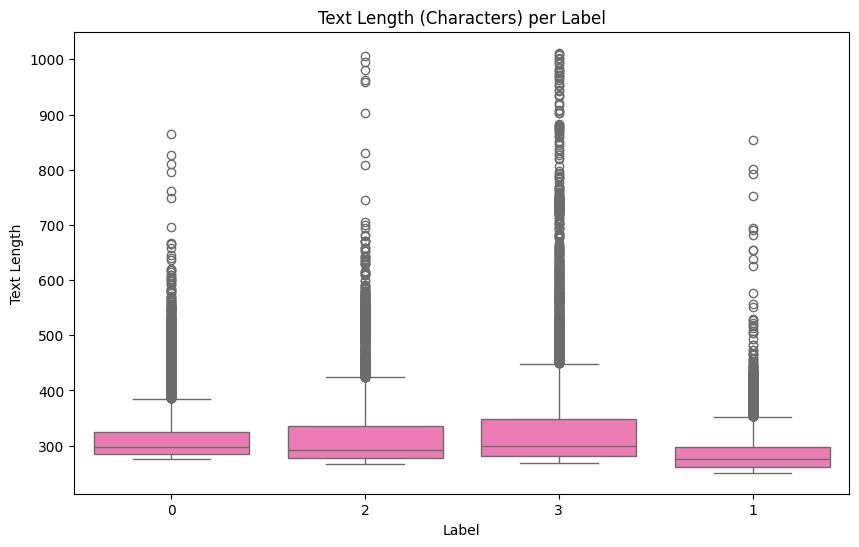

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=train_df, hue='label', palette=['#ff69b4'] * train_df['label'].nunique(), legend=False)
plt.title("Text Length (Characters) per Label")
plt.xlabel("Label")
plt.ylabel("Text Length")
plt.show()

The boxplot below, shows word counts per label. All labels have similar medians. Label 3 has the most outliers, indicating longer texts.

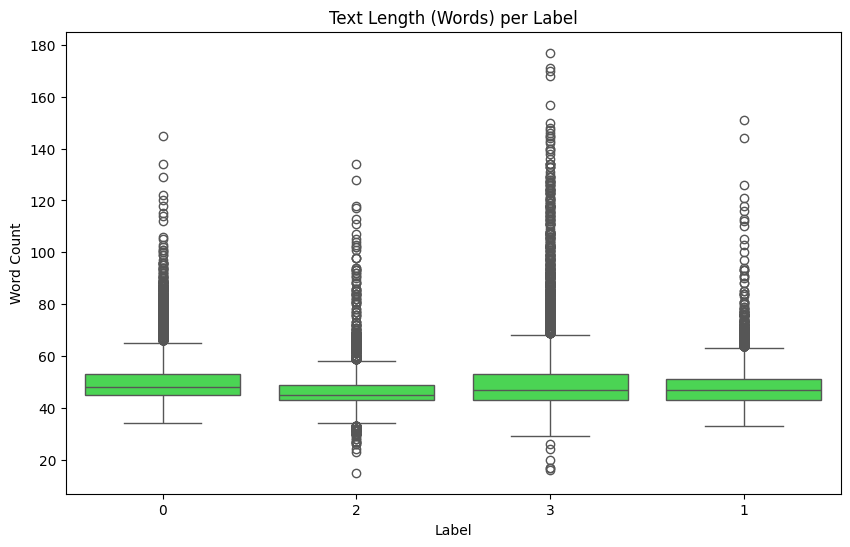

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='word_count', data=train_df, hue='label', palette=['#34eb40'] * train_df['label'].nunique(), legend=False)
plt.title("Text Length (Words) per Label")
plt.xlabel("Label")
plt.ylabel("Word Count")
plt.show()

In order to convert raw text into the token format BERT needs to understand and encode category names, these were imported.

In [63]:
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder

This code initializes the BERT tokenizer and encodes text labels into numerical values for training and testing. Our initial labels were already in the form 0, 1, 2, 3 but I found it a better practise to use label encoder anyway, to make sure we have encoded labels.

In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
label_encoder = LabelEncoder()
train_df['label_enc'] = label_encoder.fit_transform(train_df['label'])
test_df['label_enc'] = label_encoder.transform(test_df['label'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [34]:
train_df

,text,label,text_length,word_count,label_enc
0,"U.S. Strikes Zarqawi Network, Killing 15 BAGHD...",0,315,49,0
1,MGM shares jump 7.5 pct; report suggests deal ...,2,267,46,2
2,Logitech launches laser-tracking mouse SAN FRA...,3,408,60,3
3,Orb Unveils New Service for Digital Media (AP)...,3,324,54,3
4,"Norwegian police hunt for motive, robbers in M...",0,309,51,0
...,...,...,...,...,...
29995,Two Apes Arrive at Education Center (AP) AP - ...,3,269,50,3
29996,Japan Greets U.S. Army Deserter Jenkins (AP) A...,0,286,52,0
29997,Supreme Court Debates Teenage Executions WASHI...,0,380,62,0
29998,"Stocks End Flat, Microsoft Lifts Techs NEW YO...",2,404,47,2


This code tokenizes and pads the training and test texts to a fixed length (128), converting them into PyTorch tensors with attention masks for BERT input.

In [35]:
MAX_LEN = 128

# train
train_encodings = tokenizer(
    list(train_df['text']),
    truncation=True,
    padding='max_length',
    max_length=MAX_LEN,
    return_tensors='pt',
    return_attention_mask=True
)

# test
test_encodings = tokenizer(
    list(test_df['text']),
    truncation=True,
    padding='max_length',
    max_length=MAX_LEN,
    return_tensors='pt',
    return_attention_mask=True
)

Below it can be seen that the ['input_ids'] contains the token IDs for each input text after tokenization and padding and the ['attention_mask'] indicates which tokens are actual input (1) and which are padding (0).

In [36]:
train_encodings['input_ids']

tensor([[  101,  1057,  1012,  ...,     0,     0,     0],
        [  101, 15418,  6661,  ...,     0,     0,     0],
        [  101,  8833,  4221,  ...,     0,     0,     0],
        ...,
        [  101,  4259,  2457,  ...,     0,     0,     0],
        [  101, 15768,  2203,  ...,     0,     0,     0],
        [  101, 14721,  2180,  ...,     0,     0,     0]])

In [37]:
train_encodings['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

These imports load PyTorch and utilities for creating datasets and the BERT model specialized for sequence classification.

In [38]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification

The AGNews class defines a custom dataset for AG News that stores tokenized inputs and labels, returning them as tensors for model training or evaluation.

In [39]:
class AGNews(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [40]:
train_dataset = AGNews(train_encodings, train_df['label_enc'].tolist()) # here, the datasets are created
test_dataset = AGNews(test_encodings, test_df['label_enc'].tolist())

AdamW is an optimizer for training models with weight decay regularization, tqdm provides a progress bar to visualize the process.

In [41]:
from torch.optim import AdamW
from tqdm import tqdm

These variables store the best F1 score, corresponding model weights (best_model_state), tokenizer and hyperparameters for hyperparameter tuning.

In [42]:
best_f1 = 0.0
best_model_state = None
best_tokenizer = None
best_hparams = None

This function trains and evaluates a BERT model for sequence classification with specified hyperparameters. It tokenizes the input texts, creates datasets and dataloaders, trains the model for given epochs, evaluates accuracy and weighted F1 on the test set, prints results and finally updates global variables if it achieves the best F1 score so far. It returns accuracy, F1score and the trained model.

In [43]:
def train_and_evaluate(batch_size, max_len, lr, train_texts, train_labels, test_texts, test_labels, device, tokenizer, epoch):
    global best_f1, best_model_state, best_tokenizer, best_hparams
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_len)
    test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_len)

    train_dataset = AGNews(train_encodings, train_labels)
    test_dataset = AGNews(test_encodings, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epoch):
        for batch in tqdm(train_loader, desc=f"Train BS={batch_size}, ML={max_len}, LR={lr:.0e}", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            outputs.loss.backward()
            optimizer.step()

    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask=attention_mask).logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"[BS={batch_size}, ML={max_len}, LR={lr:.0e}] Accuracy: {acc:.4f}, F1: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_model_state = model.state_dict()
        best_tokenizer = tokenizer
        best_hparams = (batch_size, max_len, lr)

    return acc, f1, model


These imports are for generating all combinations of hyperparameters (product) for grid search and calculating evaluation metrics (accuracy_score, f1_score) to assess model performance.

In [44]:
from itertools import product
from sklearn.metrics import accuracy_score, f1_score

After checking gpu usage, 4 models are trained with batch sizes 16, 32 and learning rates 2e-5, 3e-5. My first goal was to experiment using batch sizes 8, 16, 32 ; max lengths 128, 256 and learning rates 2e-5, 3e-5, 5e-5 with epoch=3. However due to gpu limitations and the intense time expenditure, I decreased the experimental hyperparameter count and I made epoch=1.

In [ ]:
if (torch.cuda.is_available()):
  print("cuda")
  device = torch.device("cuda")
else:
  print("cpu")
  device = torch.device("cpu")


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_texts = train_df['text'].tolist()
train_labels = train_df['label_enc'].tolist()
test_texts = test_df['text'].tolist()
test_labels = test_df['label_enc'].tolist()

batch_sizes = [16, 32]
max_lengths = [128]
learning_rates = [2e-5, 3e-5]

results = []

for bs, ml, lr in product(batch_sizes, max_lengths, learning_rates):
    acc, f1 = train_and_evaluate(bs, ml, lr, train_texts, train_labels, test_texts, test_labels, device, tokenizer, 1)
    results.append((bs, ml, lr, acc, f1))


cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BS=16, ML=128, LR=2e-05] Accuracy: 0.9299, F1: 0.9299


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BS=16, ML=128, LR=3e-05] Accuracy: 0.9233, F1: 0.9234


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BS=32, ML=128, LR=2e-05] Accuracy: 0.9226, F1: 0.9224


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BS=32, ML=128, LR=3e-05] Accuracy: 0.9112, F1: 0.9109


Best accuracy (92.99%) and F1 score (92.99%) achieved with batch size 16 and learning rate 2e-5. Increasing batch size to 32 or learning rate to 3e-5 generally decreases performance slightly.

I will progress with these values.

In [ ]:
df = pd.DataFrame(results, columns=['Batch Size', 'Max Length', 'Learning Rate', 'Accuracy', 'F1 Score'])
df = df.sort_values(by='F1 Score', ascending=False)
df


,Batch Size,Max Length,Learning Rate,Accuracy,F1 Score
0,16,128,0.00002,0.929868,0.929925
1,16,128,0.00003,0.923289,0.923357
2,32,128,0.00002,0.922632,0.922433
3,32,128,0.00003,0.911184,0.910908


Here, using the best model hyperparameter values, I trained a model with epoch=3.

In [45]:
# save best model
best_f1 = 0.0
if (torch.cuda.is_available()):
  print("cuda")
  device = torch.device("cuda")
else:
  print("cpu")
  device = torch.device("cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_texts = train_df['text'].tolist()
train_labels = train_df['label_enc'].tolist()
test_texts = test_df['text'].tolist()
test_labels = test_df['label_enc'].tolist()
acc, f1, model = train_and_evaluate(16, 128, 2e-5, train_texts, train_labels, test_texts, test_labels, device, tokenizer, 3)

cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[BS=16, ML=128, LR=2e-05] Accuracy: 0.9216, F1: 0.9216


In [46]:
import os

I saved the model for later use, using the os library.

In [48]:
model.to("cpu")
save_path = "/content/drive/MyDrive/best_bert_model"
os.makedirs(save_path, exist_ok=True)
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/best_bert_model/tokenizer_config.json',
 '/content/drive/MyDrive/best_bert_model/special_tokens_map.json',
 '/content/drive/MyDrive/best_bert_model/vocab.txt',
 '/content/drive/MyDrive/best_bert_model/added_tokens.json')

Below, I loaded the pre-saved fine-tuned BERT model and its tokenizer and set the model to evaluation mode.

In [49]:
model_path = "/content/drive/MyDrive/best_bert_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

This code runs inference on five test samples using the model I saved previously. It tokenizes the texts, moves them to the appropriate device (gpu), and gets predictions without computing gradients. Then, it prints each sample’s truncated text, true label and predicted label for quick evaluation.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

test_texts = test_df['text'].tolist()[:5]
true_labels = test_df['label_enc'].tolist()[:5]

encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
input_ids = encodings['input_ids'].to(device)
attention_mask = encodings['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()

for i in range(5):
    print(f"Sample {i+1}:")
    print(f"  Text: {test_texts[i][:100]}...")  # first 100 chars (rest is not necessary)
    print(f"  True Label     : {true_labels[i]}")
    print(f"  Predicted Label: {preds[i]}")
    print("-" * 50)

Sample 1:
  Text: Fan v Fan: Manchester City-Tottenham Hotspur This weekend Manchester City entertain Spurs, and with ...
  True Label     : 1
  Predicted Label: 1
--------------------------------------------------
Sample 2:
  Text: Paris Tourists Search for Key to 'Da Vinci Code' (Reuters) Reuters - A funny thing happened on the w...
  True Label     : 0
  Predicted Label: 3
--------------------------------------------------
Sample 3:
  Text: Net firms: Don't tax VoIP The Spanish-American War is over and a "temporary" tax created to pay for ...
  True Label     : 3
  Predicted Label: 3
--------------------------------------------------
Sample 4:
  Text: Dependent species risk extinction The global extinction crisis is worse than thought, because thousa...
  True Label     : 3
  Predicted Label: 3
--------------------------------------------------
Sample 5:
  Text: EDS Is Charter Member of Siebel BPO Alliance (NewsFactor) NewsFactor - Siebel Systems (Nasdaq: SEBL)...
  True Label     :

The output above, shows the model's predictions on 5 test samples. It correctly classified 4 out of 5 texts. Sample 2 was misclassified. Its true label was 0, the model predicted it as 3. The rest of the samples were predicted correctly, showing good performance in this tiny dataset of 5.

### Section 2

The imports are for working with Gemini, handling json data and using regular expressions, respectively.

In [64]:
import google.generativeai as genai
import json
import re

I took an API key from Google Gemini's website.

Used the 1.5 flash model because 1.5 pro didn't work on colab, perhaps due to colab free version limitations.

I gave the first data of train.csv as input and wrote a clear prompt.

In [67]:
genai.configure(api_key="MY_API_KEY") # removed for security :)

model = genai.GenerativeModel("models/gemini-1.5-flash")

input_article = """U.S. Strikes Zarqawi Network, Killing 15 BAGHDAD, Iraq - U.S. warplanes, tanks and artillery repeatedly hit at Abu Musab al-Zarqawi's terror network in the insurgent stronghold of Fallujah on Saturday, while two British Muslim leaders came to Baghdad to try to convince his followers to release a British hostage..."""

prompt = f"""
You will be given a raw news article. Your task is to:
1. Generate a suitable title.
2. Rewrite the article to be well-written and professionally structured.

Return your response in the following JSON format:
{{
  "title": "Your generated title here",
  "article": "Your rewritten professional article here"
}}

ARTICLE:
{input_article}
"""

I generated the response and used regex to remove the json marks to print the output clearly. Below, the train.csv first row data's output is given.

In [68]:
response = model.generate_content(prompt)
response_text = response.parts[0].text.strip()

if response_text.startswith("```"):
    response_text = re.sub(r"^```(?:json)?\n|\n```$", "", response_text.strip(), flags=re.IGNORECASE)

try:
    result = json.loads(response_text)
    print("Title:\n", result["title"])
    print("\nArticle:\n", result["article"])
except json.JSONDecodeError as e:
    print("Failed to parse model response as JSON.")
    print("Error:", str(e))
    print("Raw response:")
    print(response_text)

Title:
 US Forces Launch Major Offensive Against Zarqawi Network in Fallujah, Killing 15

Article:
 BAGHDAD, Iraq – A significant US military operation targeted the terrorist network of Abu Musab al-Zarqawi in the insurgent-held city of Fallujah on Saturday.  US warplanes, tanks, and artillery launched repeated strikes, resulting in the deaths of 15 individuals affiliated with the network.  Concurrently, two British Muslim leaders arrived in Baghdad in an attempt to negotiate the release of a British hostage held by Zarqawi's followers.  The details surrounding the hostage situation and the specifics of the military operation remain limited, pending further official statements.


### Section 3

In the last section, I will combine section 1 and 2. To begin with, I am loading my model from section 1 again.

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/best_bert_model')
model.to(device)
model.eval()

# I need the AG News labeling as text for this section. This information is found on the internet (hugging face).
label_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

In [71]:
llm_model = genai.GenerativeModel("models/gemini-1.5-flash")

I am going to put the last 5 rows of train.csv in my pipeline.

In [72]:
last_5 = train_df.tail(5)

I imported pprint because when I plain printed the results below, they were in a long single line. It was not looking very clear. pprint makes the nested output look clear.

In [75]:
import pprint

Below, I created the pipeline. It first predicts the category of a news article using the pre-saved model. Then uses Gemini (Google's LLM), to generate a title and article. Finally, it prints the results (category, title, article).

In [76]:
def predict_category(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_label = torch.argmax(outputs.logits, dim=1).item()
    return label_map[predicted_label]

def rewrite_article_with_title(article_text):
    prompt = f"""
You will be given a raw news article. Your task is to:
1. Generate a suitable title.
2. Rewrite the article to be well-written and professionally structured.

Return your response in the following JSON format:
{{
  "title": "Your generated title here",
  "article": "Your rewritten professional article here"
}}

ARTICLE:
{input_article}
"""
    response = llm_model.generate_content(prompt)
    raw = response.text.strip()

    raw = re.sub(r"^```(?:json)?\n*|\n*```$", "", raw)
    return json.loads(raw)

results = []

for idx, row in last_5.iterrows():
    raw_article = row["text"]
    category = predict_category(raw_article)
    try:
        rewritten = rewrite_article_with_title(raw_article)
        results.append({
            "category": category,
            "title": rewritten["title"],
            "article": rewritten["article"]
        })
    except Exception as e:
        results.append({
            "category": category,
            "title": "[Error Generating Title]",
            "article": f"[Error: {e}]"
        })

pprint.pprint(results, sort_dicts=False)

[{'category': 'Sci/Tech',
  'title': 'US Forces Launch Major Offensive Against Zarqawi Network in '
           'Fallujah, Killing 15',
  'article': 'BAGHDAD, Iraq —  U.S. forces launched a significant offensive '
             "against Abu Musab al-Zarqawi's terrorist network in the "
             'insurgent-held city of Fallujah on Saturday.  The operation '
             'involved sustained air strikes, tank fire, and artillery '
             'barrages.  The assault resulted in the deaths of 15 individuals '
             'affiliated with the network.  Concurrently, two British Muslim '
             'leaders arrived in Baghdad in an attempt to negotiate the '
             "release of a British hostage held by Zarqawi's group.  The "
             'details surrounding the hostage situation and the ongoing '
             'negotiations remain undisclosed.'},
 {'category': 'World',
  'title': 'US Forces Launch Major Offensive Against Zarqawi Network in '
           'Fallujah, Killing 15',
  

I used AI assistance at the BERT implementation since I had no prior experience. However, I read and understood everything that I am submitting in this notebook.

Potential improvements overall: if I didn't have colab gpu limitations, I would have used a validation set to do more hyperparameter tuning. To work around these constraints, I had to rotate between three different g-mail accounts just to complete the training. Upgrading to Colab Pro (or using a more stable GPU environment) could have significantly improved the process and experimentation.

### Thank you for reading :)